In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["PLOT_LIB_PATH"] = "/cluster/home/mpundir/dev"

import jax

jax.config.update("jax_compilation_cache_dir", os.environ["JAX_CACHE_DIR"])
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import numpy as np

In this example, we solve a lineear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix. We use the Fourier-Galerkin method to solve the problem.

We import the necessary modules and set up the environment. The module `spectralsolvers` contains the operators and solvers for the Fourier-Galerkin method. We import the `fourier_galerkin` module to create the Fourier-Galerkin operator, `spatial` module to create the spatial operators, `tensor` module to create the tensor operators, and `fft` module to create the FFT and IFFT operators. We import the `conjugate_gradient_while` and `newton_krylov_solver` modules to create the solvers.


The module `plottwist` contains the plotting functions. The module `cmcrameri` contains the colormaps.

In [2]:
from spectralsolvers.operators import spatial, tensor, fourier_galerkin
from spectralsolvers.fft.transform import _fft, _ifft
from spectralsolvers.solvers.linear import conjugate_gradient_while
from spectralsolvers.solvers.nonlinear import newton_krylov_solver

from functools import partial

from skimage.morphology import disk, rectangle, ellipse
import equinox as eqx
from typing import Callable

import sys  
sys.path.append(os.environ["PLOT_LIB_PATH"])
from plottwist.decorators import plot, subplots, imshow, imshow_grid, STYLE_PATH
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

To simplify the execution of the code, we define a `ElasticityOperator` class that contains the Fourier-Galerkin operator, the spatial operators, the tensor operators, and the FFT and IFFT operators. The `__init__` method initializes the operator and the `__call__` method computes the stresses in the real space given as 

$$
\mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\sigma) \right)


$$

In [29]:
class ElasticityOperator(eqx.Module):
    Ghat: jnp.ndarray
    funcs: dict[str, Callable]
    elasticity_dof_shape: tuple[int, ...]

    def __init__(
        self,
        N,
        ndim,
        length,
        compute_stress,
        compute_tangent,
        gradient_operator=spatial.Operator.rotated_difference,
    ):
        self.Ghat = fourier_galerkin.compute_projection_operator_legacy(
            grid_size=(N,) * ndim, operator=gradient_operator, length=length
        )
        self.funcs = {}
        self.funcs["fft"] = jax.jit(partial(_fft, N=N, ndim=ndim))
        self.funcs["ifft"] = jax.jit(partial(_ifft, N=N, ndim=ndim))
        self.funcs["compute_tangent"] = compute_tangent
        self.funcs["compute_stress"] = compute_stress
        self.elasticity_dof_shape = (ndim, ndim) + (N,) * ndim



    def __call__(self, deps, args=None):
        deps = deps.reshape(self.elasticity_dof_shape)
        dsigma = self.funcs["compute_tangent"](deps, args)

        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](dsigma)))
        ).reshape(-1)
    
    def residual(self, deps : jnp.ndarray, args=None):
        sigma = self.funcs["compute_stress"](deps, args)
        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](sigma)))
        ).reshape(-1)

We define the grid size and the length of the RVE and construct the structure of the RVE.

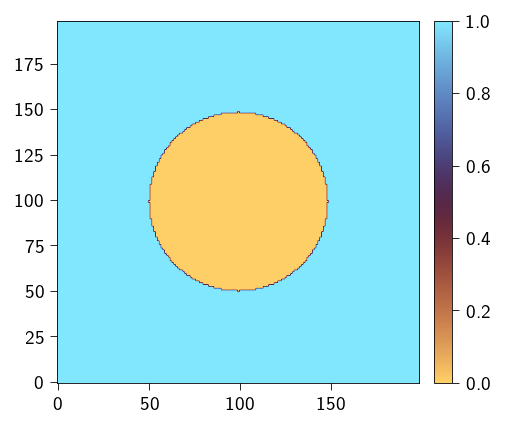

In [30]:
N = 199
shape = (N, N)
length = 1.
ndim = 2

grid_size = (N,) * ndim
elasticity_dof_shape = (ndim, ndim) + grid_size



@imshow(cmap=cmc.managua, enable=True)
def create_structure(N):
    Hmid = int(N / 2)
    Lmid = int(N / 2)
    r = int(N / 4)

    structure = np.ones((N, N))
    structure[Hmid - r : Hmid + r +1, Lmid - r : Lmid + r+1] -= disk(r)

    return structure

structure = create_structure(N)

Next, we define the material parameters.

In [31]:
# material parameters + function to convert to grid of scalars
@partial(jax.jit, static_argnames=['inclusion', 'solid'])
def param(X, inclusion, solid):
    props = inclusion*jnp.ones_like(X)*(1-X) + solid*jnp.ones_like(X)*(X)
    return props

In [32]:
# material parameters
phase_contrast = 1/1e3

# lames constant
lambda_modulus = {"solid": 1.0, "inclusion": phase_contrast}
shear_modulus = {"solid": 1.0, "inclusion": phase_contrast}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3

In [33]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

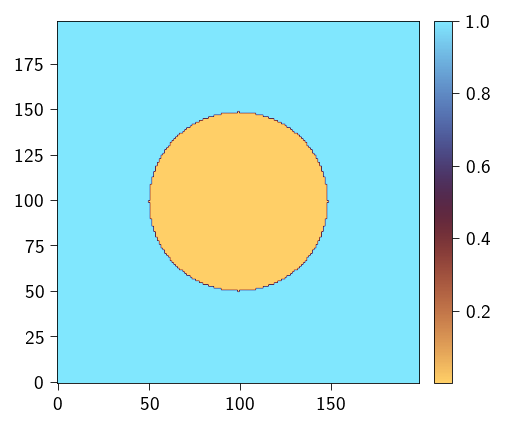

In [34]:
imshow(cmap=cmc.managua, enable=True, return_val=False)(lambda x : x)(λ0)

The linear elasticity strain energy is given as 
$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [35]:
@jax.jit
def strain_energy(eps, _):
    eps_sym = 0.5 * (eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym))
    )
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

In [36]:
elasticity_op = ElasticityOperator(
    N,
    ndim,
    length,
    gradient_operator=spatial.Operator.rotated_difference,
    compute_tangent=sigma,
    compute_stress=sigma
)

In [37]:
applied_strains = jnp.diff(jnp.linspace(0, 2e-1, num=20))

eps = jnp.zeros(elasticity_dof_shape)
deps = jnp.zeros(elasticity_dof_shape)

for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps = deps.at[0, 0].set(deps_avg)
    b = -elasticity_op(deps)
    eps = jax.lax.add(eps, deps)
    
    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        A=elasticity_op,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
        additionals=None,
    )
    eps = final_state[2]

Converged, Residual value : 6.291290356541416e-09
Converged, Residual value : 7.180154085095294e-09
Converged, Residual value : 9.968313749638486e-09
Converged, Residual value : 6.032612676509759e-09
Converged, Residual value : 8.833653055975172e-09
Converged, Residual value : 6.364067506878744e-09
Converged, Residual value : 7.30704548479089e-09
Converged, Residual value : 9.258928779817055e-09
Converged, Residual value : 6.6876969678678385e-09
Converged, Residual value : 5.037203134769417e-09
Converged, Residual value : 9.423773312279782e-09
Converged, Residual value : 6.268315695346166e-09
Converged, Residual value : 9.930147371919348e-09
Converged, Residual value : 7.976346452072723e-09
Converged, Residual value : 5.65491402372033e-09
Converged, Residual value : 9.291455974749703e-09
Converged, Residual value : 9.063216579472839e-09
Converged, Residual value : 5.903031650067525e-09
Converged, Residual value : 6.702516631385079e-09


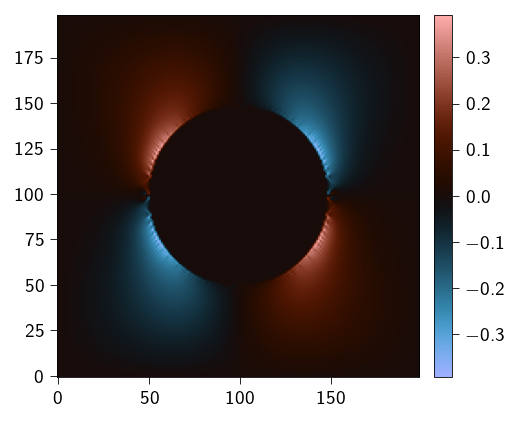

In [39]:
sig = sigma(final_state[2], None)
imshow(cmap=cmc.berlin, enable=True, return_val=False)(lambda x : x)(sig.at[0, 1].get()*(structure))

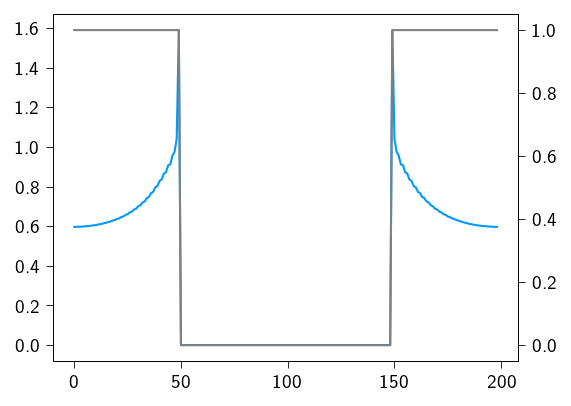

In [40]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(4,3))
ax = plt.axes()
ax.plot(sig.at[0, 0].get()[int(N/2), :]*structure[int(N/2), :])


ax2 = ax.twinx()
ax2.plot(structure[int(N/2), :], color='gray')
plt.show()